<style type="text/css">
.reveal h1 {
    font-size: 2em;
}
</style>

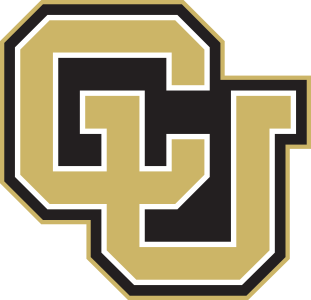

# Lecture 03, hands-on: $K$-Means
*(CPBS 7602: Introduction to Big Data in the Biomedical Sciences)*

By __Milton Pividori__<br>Department of Biomedical Informatics<br>University of Colorado Anschutz Medical Campus

# Goals
* Identify the components of an unsupervised learning problem.
* Use sklearn for clustering analysis and familiarize yourself with the API.
* Basic understanding of centroid-based algorithms ($k$-means) and other algorithms.
* Clustering in practice: feature scaling and interpretability.

# Reading Material

Check out different resources and documentation from sklearn.

* [Clustering guide](https://scikit-learn.org/1.5/modules/clustering.html) from sklearn:
  * Introduction to **different clustering methods**.
  * Clustering **performance evaluation**:
    * **When we know** the ground-truth (external metrics):
      * Based on Rand Index, such as ARI.
      * Based on mutual information, such as NMI.
    * **When we don't know** the ground-truth (internal metrics):
      * Silhouette coefficient
      * Calinski-Harabasz Index
      * Davies-Bouldin Index

# Modules

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist
from sklearn import cluster
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from sklearn.metrics import normalized_mutual_info_score as nmi

In [2]:
# load modules

# Dataset 1

This is Four Gaussians, original.

Load dataset. Feature names have the format `f[NUMBER]`. The column "labels", if present, contains the true labels/clusters.

In [3]:
# load dataset
data = pd.read_csv(
    "https://www.dropbox.com/scl/fi/8elyky9mtq9nser82xk05/dataset01.tsv?rlkey=wlue2ejkkyen8ghdxah6yqso2&st=n9x9muq9&dl=1",
    sep="\t",
)

## Question 1

How many objects ($n$) and features ($d$) are in this dataset?

In [4]:
data.shape

(100, 13)

In [5]:
data.head()

f1        f2        f3        f4        f5        f6        f7  \
0 -0.330916 -0.411204  1.806458  3.881925  1.703582  0.184864  1.565088   
1  0.005613 -0.003614  0.177467  2.373105  1.515870  2.381005  2.565380   
2 -0.050342 -0.338685  2.532612  0.597579  2.660178  2.668388  0.638148   
3  0.100639  0.693432  2.062112  2.031477  2.613821  3.768640  2.383001   
4 -0.160311 -0.576029  2.931509  1.552599  3.799989  1.763680  2.892516   

         f8        f9       f10       f11       f12  labels  
0  1.386821  1.942868  0.640872  1.592145  3.250613       1  
1  2.253157  2.118793  0.798179  0.824951  1.711693       1  
2  2.091127  2.294401  0.355153  0.134495  1.924682       1  
3  1.690449  1.502907  1.180356  0.706819  0.027658       1  
4  0.358567  2.479182  1.460836  3.351244  0.317846       1

In [6]:
data_labels = data.pop("labels")

In [7]:
data.shape

(100, 12)

In [8]:
# we take a look at the features distributions
data.describe()

f1          f2          f3          f4          f5          f6  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     1.426425    1.222585    2.122137    2.034657    2.047784    1.901838   
std      2.762913    3.476864    1.169307    1.143062    1.063029    1.185629   
min     -4.539012   -5.190981    0.073070    0.033522    0.070147    0.012054   
25%     -0.487561   -1.019238    1.166957    1.018976    1.270292    0.853160   
50%      1.183115    0.806465    2.049049    2.021329    2.055746    1.907358   
75%      3.929524    4.200504    3.139445    3.056537    2.837758    2.781726   
max      6.508632    6.873952    3.968635    3.980859    3.954391    3.979962   

               f7          f8          f9         f10         f11         f12  
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000  
mean     1.814660    1.972853    2.160616    1.802824    1.945195    2.067451  
std      1.080893    1.161838    1.157607    1.147469    1.174753    1.174859  
min      0.048035    0.049635    0.014697    0.088058    0.023665    0.017672  
25%      0.789670    0.892831    1.247181    0.764301    0.825872    1.193729  
50%      1.897732    2.149544    2.183210    1.701763    1.962398    2.139220  
75%      2.641203    2.915272    3.147419    2.835454    2.944727    3.221551  
max      3.825164    3.981973    3.979669    3.899856    3.958024    3.975148

_Answer_: add answer

_Answer_: 100 objects, 12 features.

## Question 2

Does this dataset have the ground truth (or "true") labels/clusters?
How many clusters are present in this ground truth, and how many objects are in each "true" cluster?
If we ran a clustering algorithm on the data, which metrics can we use to measure performance given the data?

In [9]:
data_labels.value_counts()

labels
1    25
2    25
3    25
4    25
Name: count, dtype: int64

_Answer_: add answer

_Answer_: Yes, four clusters, 25 objects each. We can compute all external and internal metrics.

## Question 3

We want to understand whether there is some structure among the objects in the data.
Perform a cluster analysis using $K$-Means to answer the following questions:
1. Are there stable clusters in the data?
2. What are the optimal parameters of a $K$-Means model that maximize the agreement with the true labels? Use at least two different metrics to compare the true labels with the $K$-Means labels.
3. Do clustering solutions in 1. and 2. coincide? Why or why not?

In [10]:
# 1. Are there stable clusters in the data?
X = data.to_numpy()

np.random.seed(0)

KS = range(2, 11)
N_REPS = 20

ks = []
stability_scores = []

for k in KS:
    labels = []

    for _ in range(N_REPS):
        # configure K-Means to run only one time (n_init="auto"; see documentation)
        # to generate more diversity in the results
        model = cluster.KMeans(n_clusters=k, n_init="auto")
        labels.append(model.fit_predict(X))

    # compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)

    ks.extend([k] * len(ari_distances))
    stability_scores.extend(ari_distances)

In [11]:
len(ks)

1710

In [12]:
len(stability_scores)

1710

In [13]:
df_plot = pd.DataFrame({
    "k": ks,
    "stability": stability_scores,
})

In [14]:
df_plot.shape

(1710, 2)

In [15]:
df_plot.head()

k  stability
0  2   1.000000
1  2   1.000000
2  2   0.022707
3  2   1.000000
4  2   0.205271

In [16]:
df_plot["k"].value_counts()

k
2     190
3     190
4     190
5     190
6     190
7     190
8     190
9     190
10    190
Name: count, dtype: int64

<Axes: xlabel='k', ylabel='stability'>

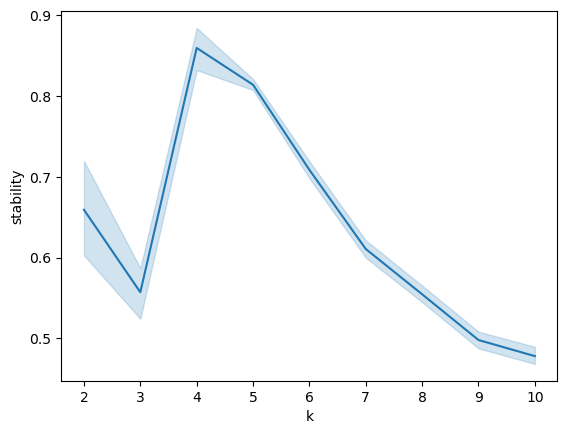

In [17]:
sns.lineplot(data=df_plot, x="k", y="stability")

In [18]:
# 2. What are the optimal parameters of a K-Means model that maximize the agreement with the true labels?
perf_ari = {}
perf_nmi = {}
for k in KS:
    # configure K-Means to run 10 times (n_init=10) and return the best partition
    model = cluster.KMeans(n_clusters=k, n_init=10)
    part = model.fit_predict(X)
    perf_ari[k] = ari(part, data_labels)
    perf_nmi[k] = nmi(part, data_labels)

In [19]:
_tmp = pd.DataFrame(
    {
        "ari": perf_ari,
        "nmi": perf_nmi,
    },
    index=KS,
)
display(_tmp)

ari       nmi
2   0.326531  0.577160
3   0.707965  0.857143
4   0.945596  0.938974
5   0.845376  0.862921
6   0.781864  0.830024
7   0.681049  0.803098
8   0.595838  0.786687
9   0.533244  0.723602
10  0.526361  0.748684

In [20]:
# just to have an idea of how well the metrics correlate
_tmp.corr()

ari       nmi
ari  1.000000  0.963637
nmi  0.963637  1.000000

_Answer_: add answer

_Answer_:
1. There are stable clusters at $K$ equal to 4, and to a lesser extent, 5.
2. $K=4$
3. Yes, the most stable clustering solution ($K=4$) is the one that maximizes the ARI with the true labels. The Consensus Index using the $K$-Means approach is able to capture the reference/true structure of the data.

## Question 4

Use at least two internal metrics to measure the quality of the clustering solutions.

1. Do they match with the true labels? Why?
2. Do they match among themselves?

In [21]:
perf_s = {}
perf_c = {}
perf_d = {}
for k in KS:
    model = cluster.KMeans(n_clusters=k, n_init=10)
    part = model.fit_predict(X)
    perf_s[k] = silhouette_score(X, part) # best value is 1, worst value is -1
    perf_c[k] = calinski_harabasz_score(X, part) # larger is better
    perf_d[k] = davies_bouldin_score(X, part) # smaller is better

In [22]:
_tmp = pd.DataFrame(
    {
        "Silhouette": perf_s,
        "CH": perf_c,
        "DB": perf_d,
    },
    index=KS,
)
display(_tmp)

Silhouette         CH        DB
2     0.281906  43.739883  1.180296
3     0.252286  38.576271  1.464689
4     0.269967  40.151523  1.385184
5     0.229322  32.449757  1.624439
6     0.177676  27.597809  1.871117
7     0.143976  24.090942  2.115634
8     0.116279  21.523668  2.173236
9     0.138238  19.561443  1.933728
10    0.109881  18.532904  2.056782

In [23]:
# just to have an idea of how well the metrics correlate
_tmp.corr()

Silhouette        CH        DB
Silhouette    1.000000  0.984337 -0.971335
CH            0.984337  1.000000 -0.952634
DB           -0.971335 -0.952634  1.000000

_Answer_: add answer

_Answer_:
1. The "true labels" ($K=4$) are among the best values, but not at the top. For Silhouette and CH (max values/best for $K=2$ and then $K=4$) and DB (min values/best for $K=2$ and then $K=4$).
2. Yes, in general, they match well.

## Question 5

Explore the different features of the dataset and find the top ones that are most helpful to capture the true labels in the data. Answer the following questions:

1. Create 2D scatterplots of the data using all possible combinations of feature pairs. _Tip:_ Look at the [`pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) function in `seaborn`.
1. What are the most important features that the algorithm used to accurately cluster the data? Are some features more important than others?
1. Create a 2-dimensional plot using the two top features you found. Include the true labels and centroids learned by $K$-Means using the $K$ with the most accurate solution. _Tip:_ the [`scatterplot`](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) function from seaborn returns a matplotlib's Axes object that you can use to draw on top of the original plot.
1. Related to the second question: think about some approaches that could be used to automatically learn the most important features that are driving clustering results.

In [24]:
model = cluster.KMeans(n_clusters=4, n_init=10)
part = model.fit_predict(X)

true_labels = pd.Series(data_labels).astype("category").rename("True labels")
cluster_labels = pd.Series(part).astype("category").rename("Cluster labels")

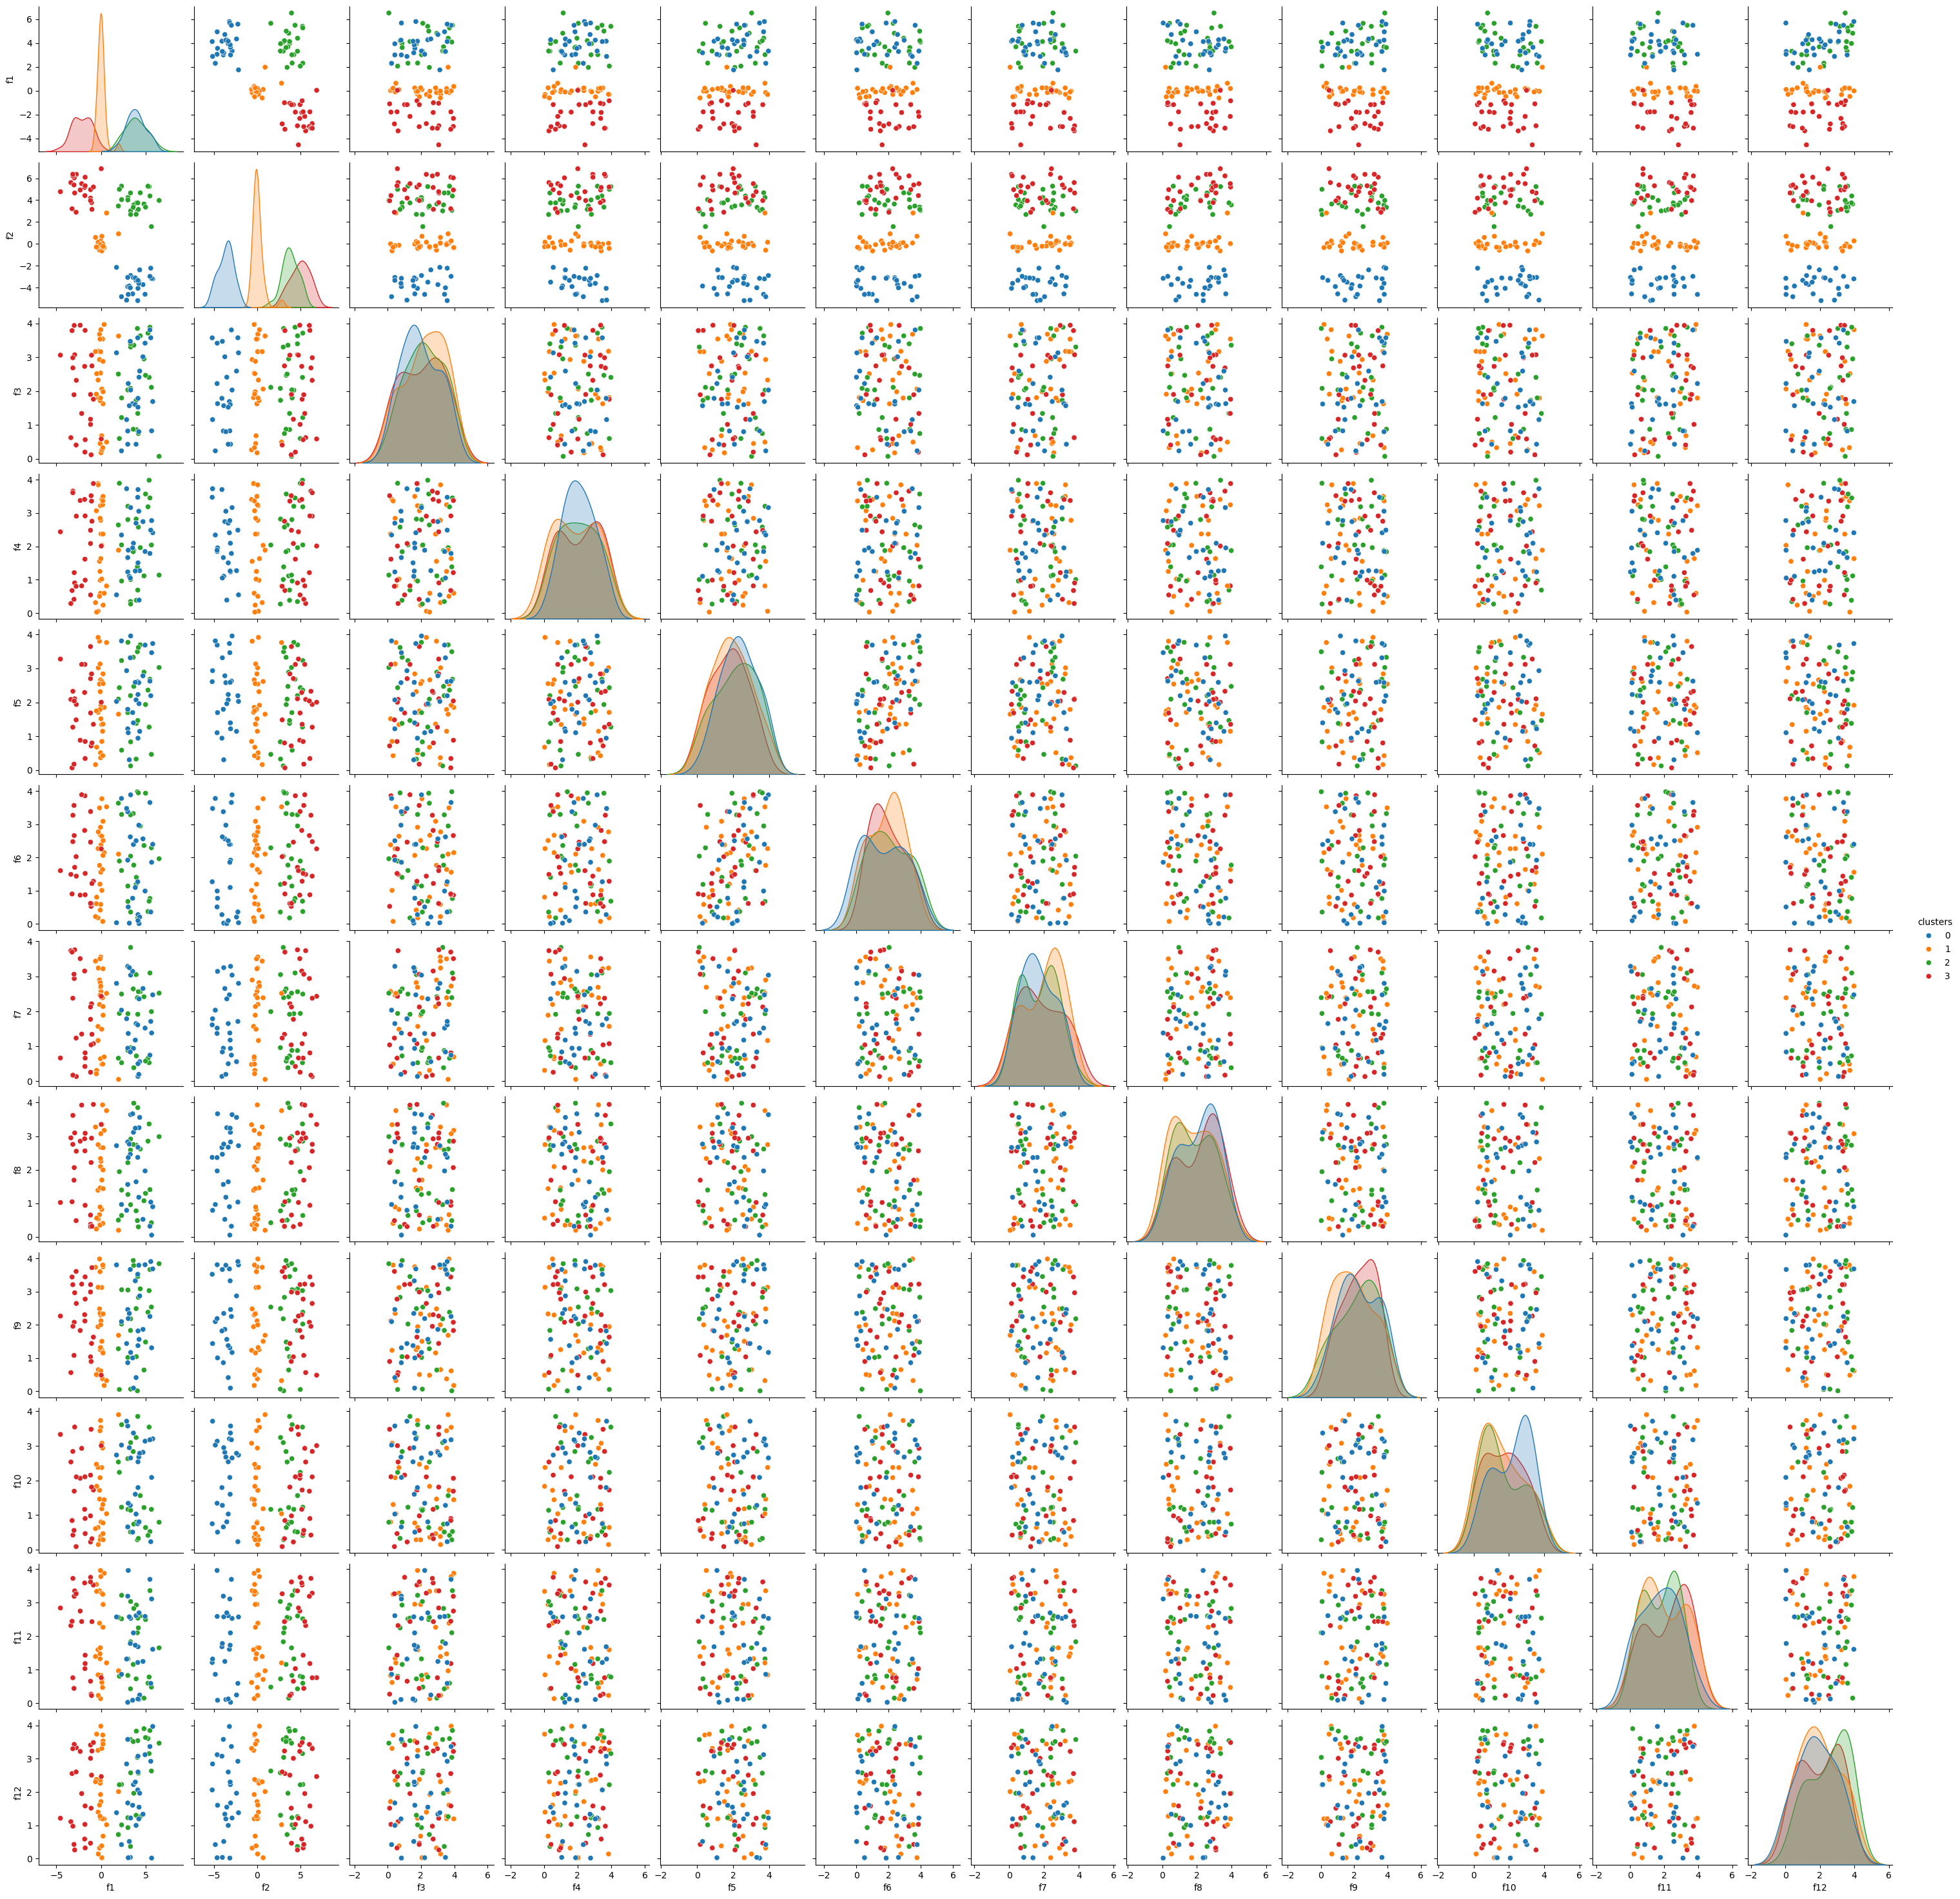

In [25]:
# 1. Create 2D scatterplots...
sns.pairplot(data.assign(clusters=cluster_labels), hue="clusters")

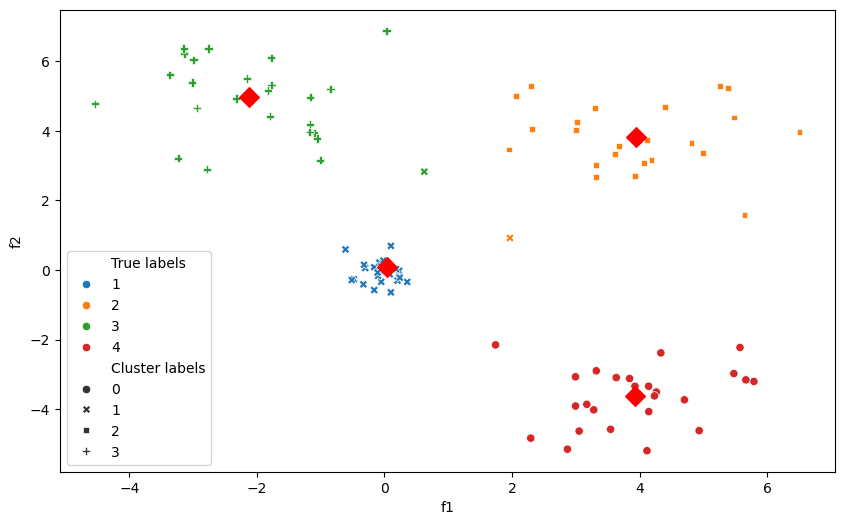

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.scatterplot(
    data,
    x="f1",
    y="f2",
    hue=true_labels,
    style=cluster_labels,
)

ax.scatter(
    model.cluster_centers_[:, 0],
    model.cluster_centers_[:, 1],
    marker="D",
    color="red",
    s=100,
)

_Answer_: add answer

_Answer_:
1. Since this is a simple and small dataset, a naive approach is to take pairs of features, plot the data (for example, using [`seaborn.pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) as above), and see which ones align better with the cluster solutions and centers. However, this takes time, it might be subjective in the structure is complex, and is infeasible on large datasets.
2. The first two features are the most important.
3. Done above.
4. Other approaches to find the most important features:
   1. Given a feature, we could compare the mean of objects inside the cluster vs objects outside the cluster, using ANOVA, t-tests, etc.
   1. Another approach, similar to the previous one, could be to use internal metrics with one feature at a time and pick those that produce the best metric value.
   1. A more advanced approach consists of using interpretable classifiers trained on labels generated by the clustering algorithm. For example, classifiers such as Decision Trees produce an easy-to-interpret tree with features that separate the labels. The approach is described [here](https://insidelearningmachines.com/decision_trees_for_clustering/).

Below, I implement some of the suggestions in **answer 4** above.

### Using internal metrics with individual features to interpret clustering results

In [27]:
data.columns

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11',
       'f12'],
      dtype='object')

In [28]:
perf_s = {}
perf_c = {}
perf_d = {}
for f in data.columns:
    d = data[[f]]
    perf_s[f] = silhouette_score(d, part)
    perf_c[f] = calinski_harabasz_score(d, part)
    perf_d[f] = davies_bouldin_score(d, part)

In [29]:
_tmp = pd.DataFrame(
    {
        "Silhouette": perf_s,
        "CH": perf_c,
        "DB": perf_d,
    },
    index=data.columns.tolist(),
)
display(_tmp)

Silhouette          CH         DB
f1     0.271619  228.587290  43.684164
f2     0.462924  470.651101   0.857222
f3    -0.085503    0.256852  57.155529
f4    -0.088956    0.167539  53.782649
f5    -0.108927    1.195079  11.066097
f6    -0.082734    0.330571  22.033477
f7    -0.093204    0.377720  22.164170
f8    -0.097979    0.540021  26.224409
f9    -0.093889    0.546720  49.264139
f10   -0.094726    1.195231  71.322936
f11   -0.099344    0.759654  37.049129
f12   -0.095968    1.562008  26.368653

In [30]:
# best at the top
_tmp.sort_values("Silhouette", ascending=False).head()

Silhouette          CH         DB
f2    0.462924  470.651101   0.857222
f1    0.271619  228.587290  43.684164
f6   -0.082734    0.330571  22.033477
f3   -0.085503    0.256852  57.155529
f4   -0.088956    0.167539  53.782649

In [31]:
# best at the top
_tmp.sort_values("CH", ascending=False).head()

Silhouette          CH         DB
f2     0.462924  470.651101   0.857222
f1     0.271619  228.587290  43.684164
f12   -0.095968    1.562008  26.368653
f10   -0.094726    1.195231  71.322936
f5    -0.108927    1.195079  11.066097

In [32]:
# best at the top
_tmp.sort_values("DB").head()

Silhouette          CH         DB
f2    0.462924  470.651101   0.857222
f5   -0.108927    1.195079  11.066097
f6   -0.082734    0.330571  22.033477
f7   -0.093204    0.377720  22.164170
f8   -0.097979    0.540021  26.224409

Features `f1` and `f2` are the best for these metrics. Note: DB does not include `f1` in its top features. Why?

### Using a Decision Tree classifier to interpret clustering results

In [33]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

In [34]:
X = data.to_numpy()

In [35]:
X.shape

(100, 12)

In [36]:
y = data_labels.to_numpy()

In [37]:
pd.Series(y).value_counts()

1    25
2    25
3    25
4    25
Name: count, dtype: int64

In [38]:
model = cluster.KMeans(n_clusters=4, n_init=10, random_state=0)
part = model.fit_predict(X)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    part,
    test_size=0.2,
    random_state=0,
    stratify=part,
)

In [40]:
X_train.shape

(80, 12)

In [41]:
X_test.shape

(20, 12)

In [42]:
clt = DecisionTreeClassifier(max_depth=3, random_state=0).fit(X_train, y_train)

In [43]:
# evaluate how well our classifier performs on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = clt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

Accuracy score: 1.0000
Precision score: 1.0000
Recall score: 1.0000
F1 score: 1.0000


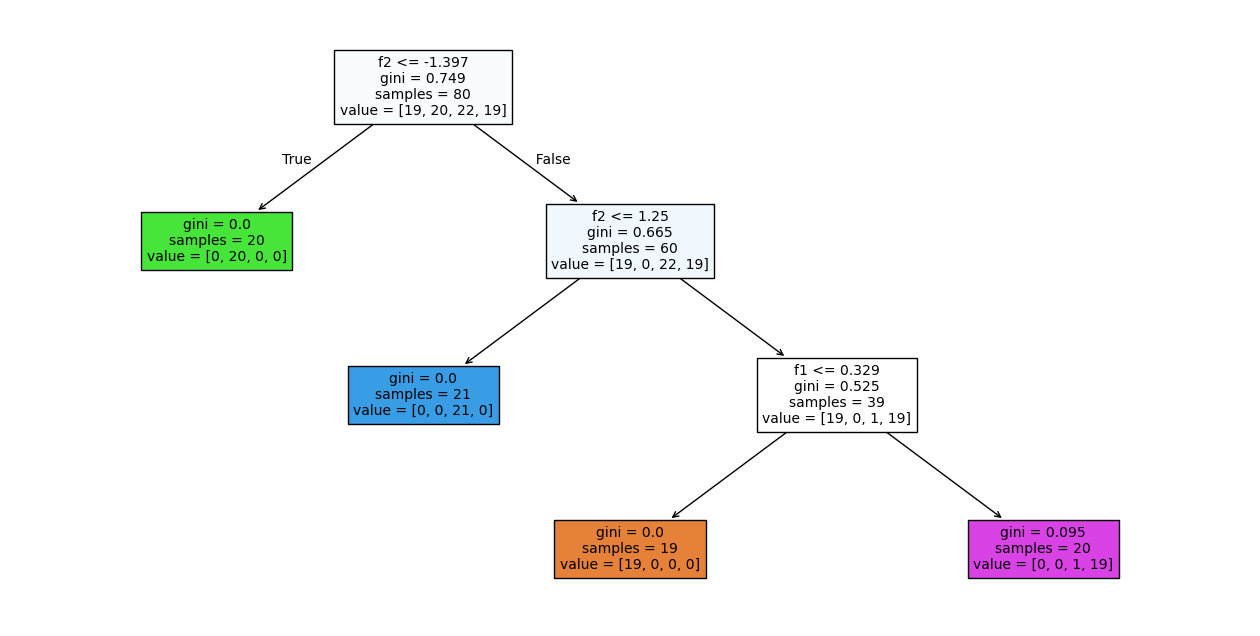

In [44]:
fig = plt.figure(figsize=(16, 8))
_ = plot_tree(
    clt,
    filled=True,
    fontsize=10,
    feature_names=data.columns.tolist(),
)

It can be seen that the classifier is only using the first and second features to separate the labels found by $K$-Means.

In this example, we have the true labels, but in a more realistic application we won't have that, and this approach can be useful to interpret our clustering results.

A few **questions**:
1. Try to look at the plot of the data we created above and understand the rules that we extract using the tree plot. Does it make sense what the classifier is doing?
2. How does this approach compare with some of the other approaches suggested above like ANOVA, t-tests, etc?

## Question 6

Let's assume that our dataset's objects are people and its features include measurements such as height (in meters, with values such as `1.55` or `1.95`) and year of birth (such as `1945` or `2001`). Clearly, these two features have different scales. Let's simulate that in our dataset:

In [45]:
# let's see what are the stats across features in the original data
data.describe()

f1          f2          f3          f4          f5          f6  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     1.426425    1.222585    2.122137    2.034657    2.047784    1.901838   
std      2.762913    3.476864    1.169307    1.143062    1.063029    1.185629   
min     -4.539012   -5.190981    0.073070    0.033522    0.070147    0.012054   
25%     -0.487561   -1.019238    1.166957    1.018976    1.270292    0.853160   
50%      1.183115    0.806465    2.049049    2.021329    2.055746    1.907358   
75%      3.929524    4.200504    3.139445    3.056537    2.837758    2.781726   
max      6.508632    6.873952    3.968635    3.980859    3.954391    3.979962   

               f7          f8          f9         f10         f11         f12  
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000  
mean     1.814660    1.972853    2.160616    1.802824    1.945195    2.067451  
std      1.080893    1.161838    1.157607    1.147469    1.174753    1.174859  
min      0.048035    0.049635    0.014697    0.088058    0.023665    0.017672  
25%      0.789670    0.892831    1.247181    0.764301    0.825872    1.193729  
50%      1.897732    2.149544    2.183210    1.701763    1.962398    2.139220  
75%      2.641203    2.915272    3.147419    2.835454    2.944727    3.221551  
max      3.825164    3.981973    3.979669    3.899856    3.958024    3.975148

In [46]:
data_scaled = data.copy()

In [47]:
from sklearn.preprocessing import minmax_scale

In [48]:
# f6 will be height
data_scaled["f6"] = minmax_scale(data["f6"], feature_range=(1.2, 2.05))

# and f7 will be year of birth
data_scaled["f7"] = np.ceil(minmax_scale(data["f7"], feature_range=(1945, 2001)))

In [49]:
# let's verify the stats/ranges of our new features
data_scaled.describe()

f1          f2          f3          f4          f5          f6  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     1.426425    1.222585    2.122137    2.034657    2.047784    1.604827   
std      2.762913    3.476864    1.169307    1.143062    1.063029    0.253984   
min     -4.539012   -5.190981    0.073070    0.033522    0.070147    1.200000   
25%     -0.487561   -1.019238    1.166957    1.018976    1.270292    1.380180   
50%      1.183115    0.806465    2.049049    2.021329    2.055746    1.606009   
75%      3.929524    4.200504    3.139445    3.056537    2.837758    1.793315   
max      6.508632    6.873952    3.968635    3.980859    3.954391    2.050000   

                f7          f8          f9         f10         f11         f12  
count   100.000000  100.000000  100.000000  100.000000  100.000000  100.000000  
mean   1971.710000    1.972853    2.160616    1.802824    1.945195    2.067451  
std      16.010284    1.161838    1.157607    1.147469    1.174753    1.174859  
min    1945.000000    0.049635    0.014697    0.088058    0.023665    0.017672  
25%    1956.750000    0.892831    1.247181    0.764301    0.825872    1.193729  
50%    1973.000000    2.149544    2.183210    1.701763    1.962398    2.139220  
75%    1984.000000    2.915272    3.147419    2.835454    2.944727    3.221551  
max    2001.000000    3.981973    3.979669    3.899856    3.958024    3.975148

It can be seen that the mean, standard deviation, minimum, and maximum values are very different now when we compare the features.

1. How does our clustering approach perform in this new dataset?
2. Why is this happening? How can we fix it? *Tip:* take a look at the [preprocessing functions in sklearn](https://scikit-learn.org/1.5/modules/preprocessing.html). Try the [StandardScaler](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

_Answer_: add answer

### Performance on new dataset

In [50]:
# 1. Are there stable clusters in the data?
X = data_scaled.to_numpy()

np.random.seed(0)

KS = range(2, 11)
N_REPS = 20

ks = []
stability_scores = []

for k in KS:
    labels = []

    for _ in range(N_REPS):
        # configure K-Means to run only one time (n_init="auto"; see documentation)
        # to generate more diversity in the results
        model = cluster.KMeans(n_clusters=k, n_init="auto")
        labels.append(model.fit_predict(X))

    # compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)

    ks.extend([k] * len(ari_distances))
    stability_scores.extend(ari_distances)

In [51]:
df_plot = pd.DataFrame({
    "k": ks,
    "stability": stability_scores,
})

In [52]:
df_plot.shape

(1710, 2)

In [53]:
df_plot.head()

k  stability
0  2        1.0
1  2        1.0
2  2        1.0
3  2        1.0
4  2        1.0

In [54]:
df_plot["k"].value_counts()

k
2     190
3     190
4     190
5     190
6     190
7     190
8     190
9     190
10    190
Name: count, dtype: int64

<Axes: xlabel='k', ylabel='stability'>

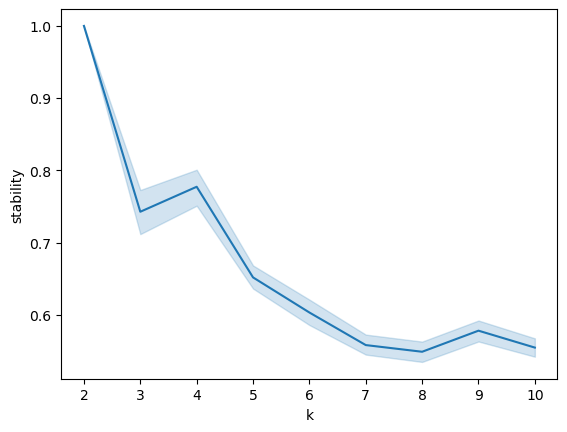

In [55]:
sns.lineplot(data=df_plot, x="k", y="stability")

In [56]:
# comparison with true labels
perf_ari = {}
perf_nmi = {}
for k in KS:
    model = cluster.KMeans(n_clusters=k, n_init=10)
    part = model.fit_predict(X)
    perf_ari[k] = ari(part, data_labels)
    perf_nmi[k] = nmi(part, data_labels)

In [57]:
_tmp = pd.DataFrame(
    {
        "ari": perf_ari,
        "nmi": perf_nmi,
    },
    index=KS,
)
display(_tmp)

ari       nmi
2   0.006349  0.020843
3  -0.000907  0.026593
4   0.003075  0.035251
5   0.005051  0.053313
6  -0.005253  0.050038
7   0.024829  0.125656
8   0.094730  0.237107
9   0.081566  0.242409
10  0.178426  0.368564

In [58]:
# extract most important features for clustering results
X = data_scaled.to_numpy()
display(X.shape)

(100, 12)

In [59]:
model = cluster.KMeans(n_clusters=4, n_init=10, random_state=0)
part = model.fit_predict(X)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    part,
    test_size=0.2,
    random_state=0,
    stratify=part,
)

In [61]:
X_train.shape

(80, 12)

In [62]:
X_test.shape

(20, 12)

In [63]:
clt = DecisionTreeClassifier(max_depth=3, random_state=0).fit(X_train, y_train)

In [64]:
# evaluate how well our classifier performs on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = clt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

Accuracy score: 1.0000
Precision score: 1.0000
Recall score: 1.0000
F1 score: 1.0000


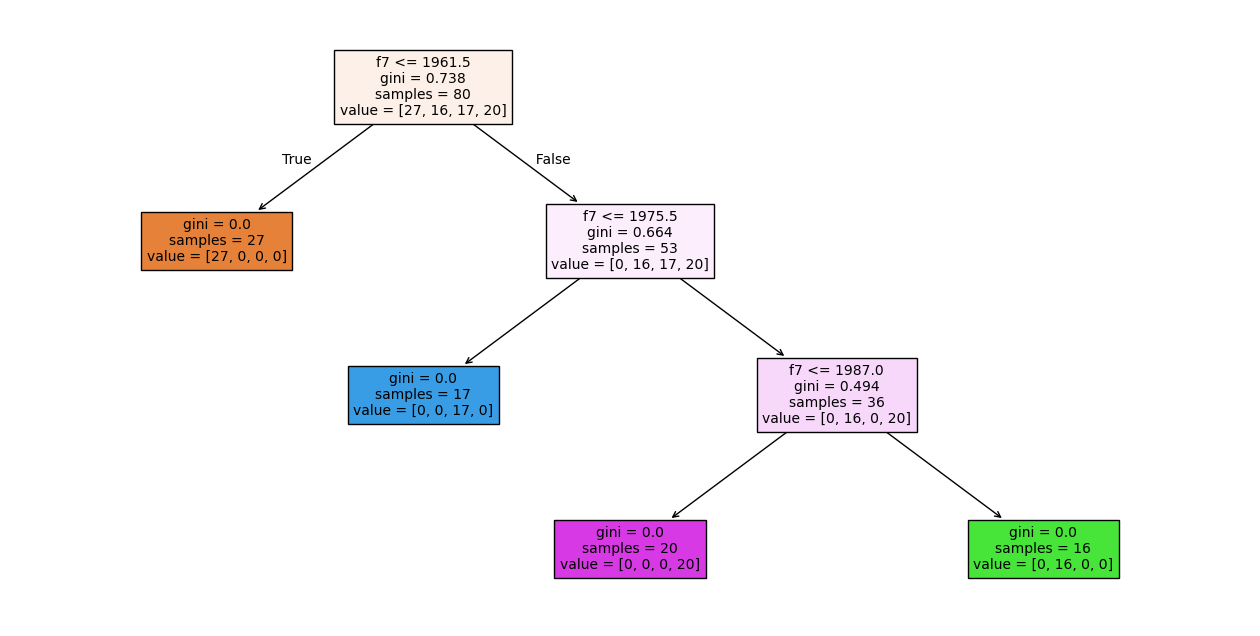

In [65]:
fig = plt.figure(figsize=(16, 8))
_ = plot_tree(clt, filled=True, fontsize=10, feature_names=data_scaled.columns.tolist())

_Answer_:
1. It performs worse! The stability of results is different, and now we don't capture the true labels.
2. This happens because there is one feature (`f7`) with a completely different scale, and this dominates the objective function of the algorithm. It's necessary to have all features on the same scale so that none dominate the rest.

**IMPORTANT:** Feature scaling is important! Even though we scaled the original features while preserving the order, the results are completely different. $K$-Means, given its objective function, is completely dominated by the feature with the largest variance.

### Let's properly standardize our data

In [66]:
from sklearn.preprocessing import StandardScaler

In [67]:
data_scaled.describe()

f1          f2          f3          f4          f5          f6  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     1.426425    1.222585    2.122137    2.034657    2.047784    1.604827   
std      2.762913    3.476864    1.169307    1.143062    1.063029    0.253984   
min     -4.539012   -5.190981    0.073070    0.033522    0.070147    1.200000   
25%     -0.487561   -1.019238    1.166957    1.018976    1.270292    1.380180   
50%      1.183115    0.806465    2.049049    2.021329    2.055746    1.606009   
75%      3.929524    4.200504    3.139445    3.056537    2.837758    1.793315   
max      6.508632    6.873952    3.968635    3.980859    3.954391    2.050000   

                f7          f8          f9         f10         f11         f12  
count   100.000000  100.000000  100.000000  100.000000  100.000000  100.000000  
mean   1971.710000    1.972853    2.160616    1.802824    1.945195    2.067451  
std      16.010284    1.161838    1.157607    1.147469    1.174753    1.174859  
min    1945.000000    0.049635    0.014697    0.088058    0.023665    0.017672  
25%    1956.750000    0.892831    1.247181    0.764301    0.825872    1.193729  
50%    1973.000000    2.149544    2.183210    1.701763    1.962398    2.139220  
75%    1984.000000    2.915272    3.147419    2.835454    2.944727    3.221551  
max    2001.000000    3.981973    3.979669    3.899856    3.958024    3.975148

In [68]:
scaler = StandardScaler().set_output(transform="pandas")
data_std = scaler.fit_transform(data_scaled)
display(data_std.describe())

f1            f2            f3            f4            f5  \
count  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02   
mean   5.995204e-17 -4.662937e-17  7.771561e-17  9.436896e-17 -5.523360e-17   
std    1.005038e+00  1.005038e+00  1.005038e+00  1.005038e+00  1.005038e+00   
min   -2.169989e+00 -1.853934e+00 -1.761206e+00 -1.759499e+00 -1.869752e+00   
25%   -6.962319e-01 -6.480314e-01 -8.209922e-01 -8.930380e-01 -7.350773e-01   
50%   -8.850639e-02 -1.202856e-01 -6.281993e-02 -1.171872e-02  7.528283e-03   
75%    9.105279e-01  8.608104e-01  8.743926e-01  8.984885e-01  7.468796e-01   
max    1.848705e+00  1.633609e+00  1.587094e+00  1.711199e+00  1.802597e+00   

                 f6            f7            f8            f9           f10  \
count  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02   
mean   6.172840e-16 -2.291500e-15  3.885781e-17  4.096723e-16  2.087219e-16   
std    1.005038e+00  1.005038e+00  1.005038e+00  1.005038e+00  1.005038e+00   
min   -1.601938e+00 -1.676707e+00 -1.663664e+00 -1.863093e+00 -1.501918e+00   
25%   -8.889472e-01 -9.391067e-01 -9.342637e-01 -7.930473e-01 -9.096154e-01   
50%    4.678836e-03  8.097912e-02  1.528449e-01  1.961611e-02 -8.851624e-02   
75%    7.458659e-01  7.714988e-01  8.152320e-01  8.567448e-01  9.044543e-01   
max    1.761590e+00  1.838666e+00  1.737972e+00  1.579306e+00  1.836735e+00   

                f11           f12  
count  1.000000e+02  1.000000e+02  
mean   5.995204e-17 -2.237099e-16  
std    1.005038e+00  1.005038e+00  
min   -1.643928e+00 -1.753491e+00  
25%   -9.576153e-01 -7.474284e-01  
50%    1.471766e-02  6.139521e-02  
75%    8.551309e-01  9.872802e-01  
max    1.722038e+00  1.631948e+00

Now our data is standardized: it has a mean of zero and a standard deviation of one across all features.

In [69]:
# 1. Are there stable clusters in the data?
X = data_std.to_numpy()

np.random.seed(0)

KS = range(2, 11)
N_REPS = 20

ks = []
stability_scores = []

for k in KS:
    labels = []

    for _ in range(N_REPS):
        # configure K-Means to run only one time (n_init="auto"; see documentation)
        # to generate more diversity in the results
        model = cluster.KMeans(n_clusters=k, n_init="auto")
        labels.append(model.fit_predict(X))

    # compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)

    ks.extend([k] * len(ari_distances))
    stability_scores.extend(ari_distances)

In [70]:
df_plot = pd.DataFrame({
    "k": ks,
    "stability": stability_scores,
})

In [71]:
df_plot.shape

(1710, 2)

In [72]:
df_plot.head()

k  stability
0  2   0.242350
1  2   0.106608
2  2   0.329653
3  2   0.543135
4  2   0.306777

In [73]:
df_plot["k"].value_counts()

k
2     190
3     190
4     190
5     190
6     190
7     190
8     190
9     190
10    190
Name: count, dtype: int64

<Axes: xlabel='k', ylabel='stability'>

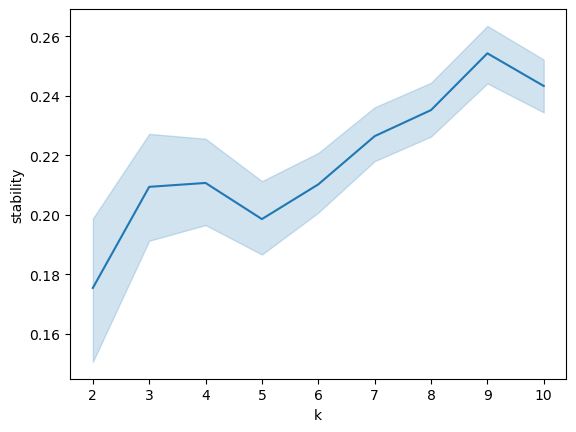

In [74]:
sns.lineplot(data=df_plot, x="k", y="stability")

In [75]:
perf_ari = {}
perf_nmi = {}
for k in KS:
    model = cluster.KMeans(n_clusters=k, n_init=10)
    part = model.fit_predict(X)
    perf_ari[k] = ari(part, data_labels)
    perf_nmi[k] = nmi(part, data_labels)

In [76]:
_tmp = pd.DataFrame(
    {
        "ari": perf_ari,
        "nmi": perf_nmi,
    },
    index=KS,
)
display(_tmp)

ari       nmi
2   0.005755  0.020209
3   0.181428  0.238240
4   0.157298  0.247226
5   0.091315  0.155590
6   0.063956  0.156537
7   0.094712  0.204211
8   0.145187  0.299462
9   0.160326  0.310935
10  0.103940  0.274355

In [77]:
model = cluster.KMeans(n_clusters=4, n_init=10, random_state=0)
part = model.fit_predict(X)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    part,
    test_size=0.2,
    random_state=0,
    stratify=part,
)

In [79]:
X_train.shape

(80, 12)

In [80]:
X_test.shape

(20, 12)

In [81]:
clt = DecisionTreeClassifier(max_depth=3, random_state=0).fit(X_train, y_train)

In [82]:
# evaluate how well our classifier performs on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = clt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

Accuracy score: 0.5500
Precision score: 0.6500
Recall score: 0.5500
F1 score: 0.5672


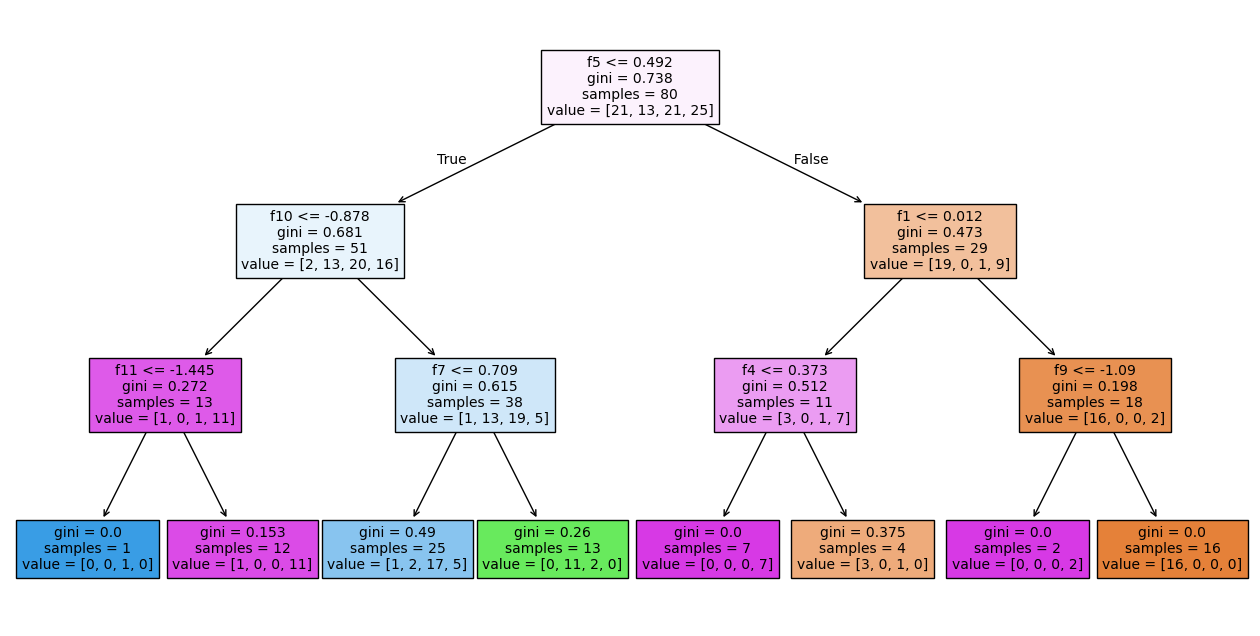

In [83]:
fig = plt.figure(figsize=(16, 8))
_ = plot_tree(clt, filled=True, fontsize=10, feature_names=data_scaled.columns.tolist())

From the tree plot, now it's clear K-Means is using all features more equally, and not focused on one alone.

Although standardizing the data is important and must be done in any cluster analysis on real data, the procedure transforms/changes the input data, and the consequences are not always clear ([it is usually good to use a range of standardization approaches](https://www.statlearning.com/); [effects of different standardization approaches on cluster analysis](https://link.springer.com/article/10.1007/BF01897163); [how to deal with outliers using the median absolute deviation instead of the standard deviation](https://www.stat.berkeley.edu/~s133/all2011.pdf)). In this artificially generated dataset (which has a ground truth), the two most important features are the first two, which have a different scale from the rest. The other 10 features are random noise. After scaling, the algorithm is no longer able to capture the true labels.

# Dataset 2

This is a dataset with no structure.

In [84]:
# load dataset
data = pd.read_csv(
    "https://www.dropbox.com/scl/fi/mfllucl6fu2awou5hg90p/dataset02.tsv?rlkey=vcbr61pr5159qo4ynh49vpq4o&st=gec1pm6r&dl=1",
    sep="\t",
)

## Previous Questions 1-5

Answer the same questions as for Dataset 1.

### Question 1

In [85]:
data.shape

(250, 4)

In [86]:
data.head()

f1        f2        f3        f4
0 -1.264053  1.527905 -0.970711  0.470560
1 -0.100697  0.303793 -1.725962  1.585095
2  0.134297 -1.106855  1.578226  0.107498
3 -0.764048 -0.775189  1.383847  0.760385
4 -0.285646  0.538367 -2.083897  0.937782

_Answer_: add answer

_Answer_: 250 objects, 4 features.

### Question 2

In [87]:
# data_labels.value_counts()

_Answer_: add answer

_Answer_: No.

### Question 3

In [88]:
# 1. Are there stable clusters in the data?
X = data.to_numpy()

np.random.seed(0)

KS = range(2, 11)
N_REPS = 20

ks = []
stability_scores = []

for k in KS:
    labels = []

    for _ in range(N_REPS):
        # configure K-Means to run only one time (n_init="auto"; see documentation)
        # to generate more diversity in the results
        model = cluster.KMeans(n_clusters=k, n_init="auto")
        labels.append(model.fit_predict(X))

    # compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)

    ks.extend([k] * len(ari_distances))
    stability_scores.extend(ari_distances)

In [89]:
len(ks)

1710

In [90]:
len(stability_scores)

1710

In [91]:
df_plot = pd.DataFrame({
    "k": ks,
    "stability": stability_scores,
})

In [92]:
df_plot.shape

(1710, 2)

In [93]:
df_plot.head()

k  stability
0  2   0.397016
1  2   0.093409
2  2   0.516458
3  2   0.126110
4  2   0.137942

In [94]:
df_plot["k"].value_counts()

k
2     190
3     190
4     190
5     190
6     190
7     190
8     190
9     190
10    190
Name: count, dtype: int64

<Axes: xlabel='k', ylabel='stability'>

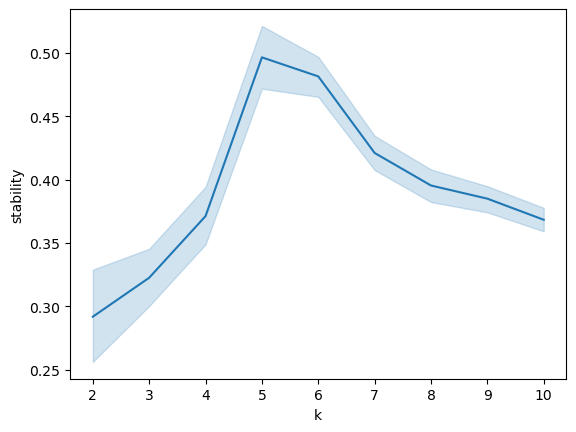

In [95]:
sns.lineplot(data=df_plot, x="k", y="stability")

_Answer_: add answer

_Answer_:
1. The most stable $K$ is at 5, but similarity (ARI) values are around 0.50, which is lower than in Dataset 1.
2. NA.
3. NA.

### Question 4

In [96]:
perf_s = {}
perf_c = {}
perf_d = {}
for k in KS:
    model = cluster.KMeans(n_clusters=k, n_init=10)
    part = model.fit_predict(X)
    perf_s[k] = silhouette_score(X, part)
    perf_c[k] = calinski_harabasz_score(X, part)
    perf_d[k] = davies_bouldin_score(X, part)

In [97]:
_tmp = pd.DataFrame(
    {
        "Silhouette": perf_s,
        "CH": perf_c,
        "DB": perf_d,
    },
    index=KS,
)
display(_tmp)

Silhouette         CH        DB
2     0.180066  59.233672  1.921182
3     0.177998  55.173893  1.674670
4     0.184859  56.163755  1.485240
5     0.194603  56.762078  1.308320
6     0.191257  53.336602  1.335647
7     0.191521  50.409881  1.295524
8     0.193205  49.381631  1.285335
9     0.187638  46.452594  1.321770
10    0.196829  45.755625  1.315282

In [98]:
_tmp.corr()

Silhouette        CH        DB
Silhouette    1.000000 -0.571468 -0.855604
CH           -0.571468  1.000000  0.680578
DB           -0.855604  0.680578  1.000000

_Answer_: add answer

_Answer_:
1. NA
2. Only Silhouette and DB, but they don't match well with CH (less than in Dataset 1).

### Question 5

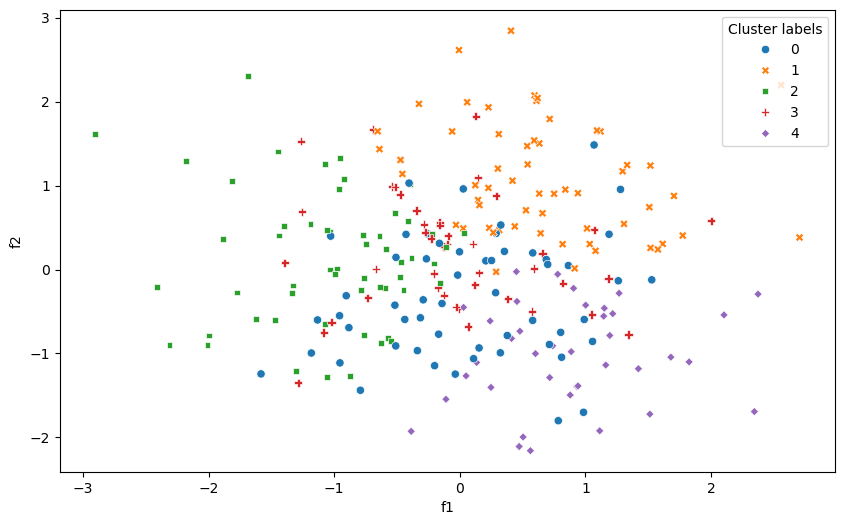

In [99]:
fig, ax = plt.subplots(figsize=(10, 6))

model = cluster.KMeans(n_clusters=5, n_init=10)
part = model.fit_predict(X)

# true_labels = pd.Series(data_labels).astype("category").rename("True labels")
cluster_labels = pd.Series(part).astype("category").rename("Cluster labels")

ax = sns.scatterplot(
    data,
    x="f1",
    y="f2",
    hue=cluster_labels,
    style=cluster_labels,
)

# ax.scatter(
#     model.cluster_centers_[:, 0],
#     model.cluster_centers_[:, 1],
#     marker="D",
#     color="red",
#     s=100,
# )

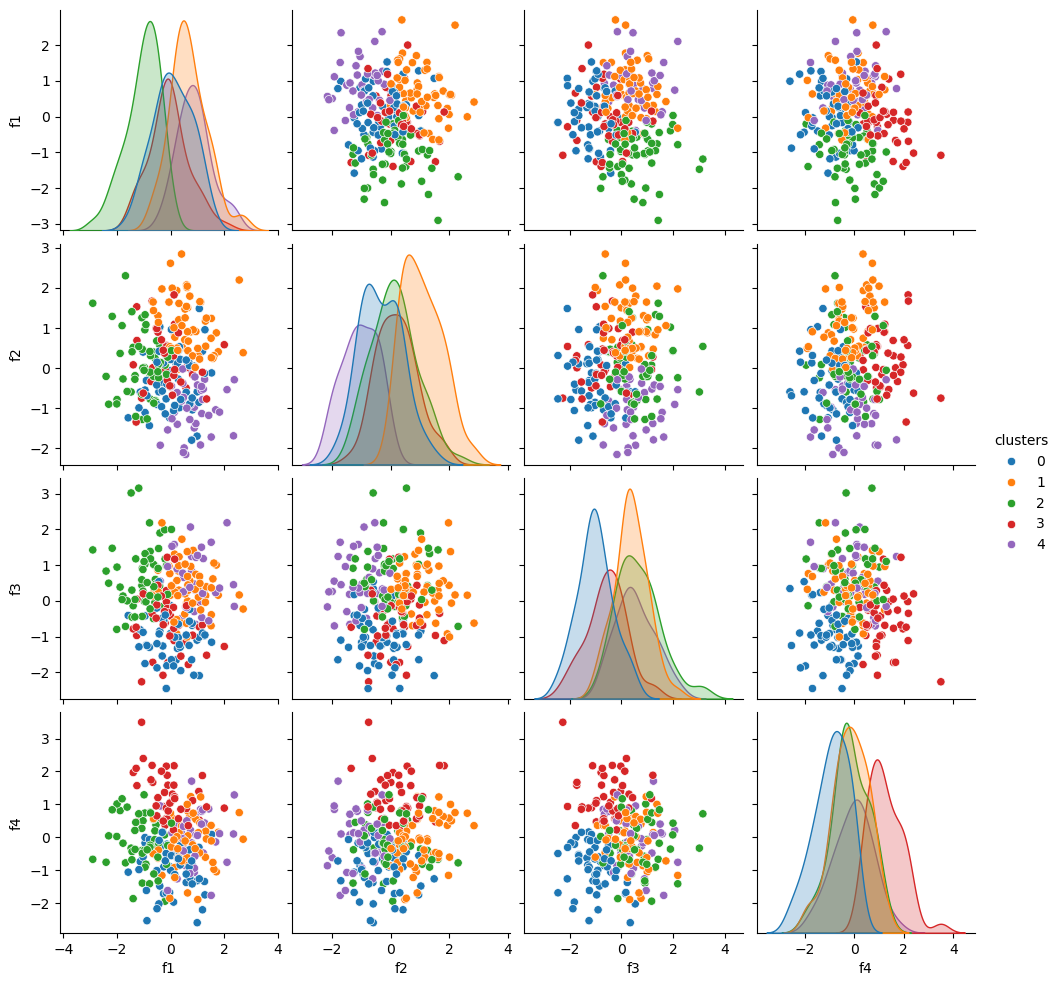

In [100]:
sns.pairplot(data.assign(clusters=cluster_labels), hue="clusters")

_Answer_: add answer

_Answer_: No feature seems to be separating clusters very well.

# Dataset 3

This is Concentric Circles (or rings).

In [101]:
# load dataset
data = pd.read_csv(
    "https://www.dropbox.com/scl/fi/2wtandc0jofhw0i4ivh1v/dataset03.tsv?rlkey=jtv6zbpaw0c5v70kd73uj2ccs&st=mkv2zlzs&dl=1",
    sep="\t",
)

## Previous Questions 1-5

Answer the same questions as for Dataset 2.

**In addition**, answer Question 7 below for this dataset.

### Question 1

In [102]:
data.shape

(250, 3)

In [103]:
data.head()

f1        f2  labels
0 -0.900411  0.431885       0
1  0.458803 -0.385274       1
2 -0.307506 -0.240035       1
3 -0.468652  0.132379       1
4 -0.195731  0.999783       0

In [104]:
data_labels = data.pop("labels")

In [105]:
data.shape

(250, 2)

_Answer_: add answer

_Answer_: 250 objects, 2 features.

### Question 2

In [106]:
data_labels.value_counts()

labels
0    125
1    125
Name: count, dtype: int64

_Answer_: add answer

_Answer_: Yes, two clusters, 125 objects each. We can compute all external and internal metrics.

### Question 3

In [107]:
# 1. Are there stable clusters in the data?
X = data.to_numpy()

np.random.seed(0)

KS = range(2, 11)
N_REPS = 20

ks = []
stability_scores = []

for k in KS:
    labels = []

    for _ in range(N_REPS):
        # configure K-Means to run only one time (n_init="auto"; see documentation)
        # to generate more diversity in the results
        model = cluster.KMeans(n_clusters=k, n_init="auto")
        labels.append(model.fit_predict(X))

    # compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)

    ks.extend([k] * len(ari_distances))
    stability_scores.extend(ari_distances)

In [108]:
len(ks)

1710

In [109]:
len(stability_scores)

1710

In [110]:
df_plot = pd.DataFrame({
    "k": ks,
    "stability": stability_scores,
})

In [111]:
df_plot.shape

(1710, 2)

In [112]:
df_plot.head()

k  stability
0  2   0.088765
1  2   0.046353
2  2   0.677684
3  2   0.001180
4  2  -0.000873

In [113]:
df_plot["k"].value_counts()

k
2     190
3     190
4     190
5     190
6     190
7     190
8     190
9     190
10    190
Name: count, dtype: int64

<Axes: xlabel='k', ylabel='stability'>

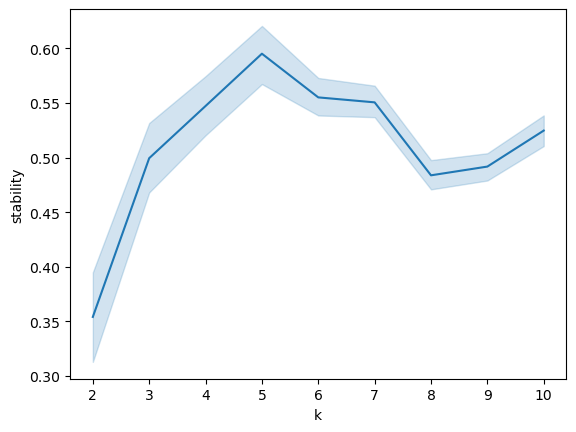

In [114]:
sns.lineplot(data=df_plot, x="k", y="stability")

In [115]:
perf_ari = {}
perf_nmi = {}
for k in KS:
    model = cluster.KMeans(n_clusters=k, n_init=10)
    part = model.fit_predict(X)
    perf_ari[k] = ari(part, data_labels)
    perf_nmi[k] = nmi(part, data_labels)

In [116]:
_tmp = pd.DataFrame(
    {
        "ari": perf_ari,
        "nmi": perf_nmi,
    },
    index=KS,
)
display(_tmp)

ari       nmi
2  -0.003002  0.000739
3  -0.005189  0.000160
4  -0.004706  0.001328
5  -0.004850  0.001682
6  -0.005315  0.001650
7   0.066527  0.153119
8   0.112343  0.269048
9   0.173286  0.377611
10  0.135883  0.317805

In [117]:
_tmp.corr()

ari       nmi
ari  1.000000  0.998933
nmi  0.998933  1.000000

_Answer_: add answer

_Answer_:
1. There seem to be stable clusters at $K$ equal to 5, and to a lesser extent, 6.
2. $K=9$, but it has a very low ARI.
3. No, they don't coincide. Maybe the true structure (that has $K=2$) cannot be captured with $K$-Means (which has specific assumptions; see below), but a solution with more clusters captures a bit better this structure.

### Question 4

In [118]:
perf_s = {}
perf_c = {}
perf_d = {}
for k in KS:
    model = cluster.KMeans(n_clusters=k, n_init=10)
    part = model.fit_predict(X)
    perf_s[k] = silhouette_score(X, part)
    perf_c[k] = calinski_harabasz_score(X, part)
    perf_d[k] = davies_bouldin_score(X, part)

In [119]:
_tmp = pd.DataFrame(
    {
        "Silhouette": perf_s,
        "CH": perf_c,
        "DB": perf_d,
    },
    index=KS,
)
display(_tmp)

Silhouette          CH        DB
2     0.351596  144.492937  1.180528
3     0.390638  201.545585  0.829852
4     0.377906  223.554783  0.810443
5     0.355877  228.053284  0.851087
6     0.326059  222.498731  0.914945
7     0.363779  213.623116  0.885224
8     0.386541  213.436145  0.846627
9     0.380527  212.883013  0.840658
10    0.424364  225.371389  0.746885

In [120]:
_tmp.corr()

Silhouette        CH        DB
Silhouette     1.00000  0.216900 -0.599740
CH             0.21690  1.000000 -0.894217
DB            -0.59974 -0.894217  1.000000

_Answer_: add answer

_Answer_:
1. No; none of them matches those with the highest agreement with true labels.
2. They don't match very well among themselves either.

### Question 5

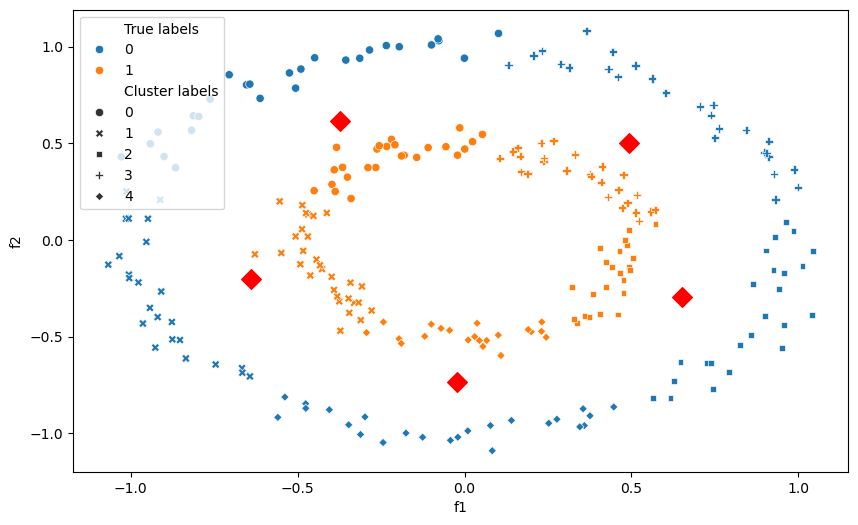

In [121]:
fig, ax = plt.subplots(figsize=(10, 6))

model = cluster.KMeans(n_clusters=5, n_init=10)
part = model.fit_predict(X)

true_labels = pd.Series(data_labels).astype("category").rename("True labels")
cluster_labels = pd.Series(part).astype("category").rename("Cluster labels")

ax = sns.scatterplot(
    data,
    x="f1",
    y="f2",
    hue=true_labels,
    style=cluster_labels,
)

ax.scatter(
    model.cluster_centers_[:, 0],
    model.cluster_centers_[:, 1],
    marker="D",
    color="red",
    s=100,
)

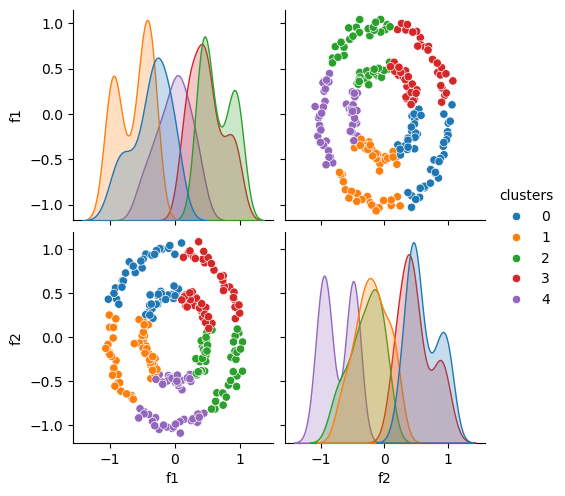

In [122]:
sns.pairplot(data.assign(clusters=cluster_labels), hue="clusters")

_Answer_: add answer

_Answer_: No feature seems to be separating clusters very well.

## Question 7

As you probably guessed after answering Question 5 (Dataset 3) and making the plot, this dataset has an unusual structure: it has two concentric circles (or rings).
It was generated using the function [`make_circles`](https://scikit-learn.org/dev/modules/generated/sklearn.datasets.make_circles.html) from sklearn.
These complex datasets are used to test different clustering and classification algorithms with different degrees of difficulty.

So here you have the **first question**:
1. $K$-Means cannot capture this structure. Why not?

Now, let's try to answer Questions 3-5 but using different clustering algorithms and explore different parameters.
Some suggestions are:
* [Spectral Clustering](https://scikit-learn.org/1.5/modules/clustering.html#spectral-clustering):
  * It computes a low-dimensional embedding of the input data where the complex data structures (such as the rings) are more apparent. Then it applies $K$-Means on this embedding.
  * A suggestion on how to run it:

    ```python
        cluster.SpectralClustering(
            n_clusters=k, affinity="nearest_neighbors", n_init=1
        )
    ```

    You can try different parameters such as `affinity` or `gamma`.
* [DBSCAN](https://scikit-learn.org/1.5/modules/clustering.html#dbscan):
  * This algorithm is very different from $K$-Means. It is not centroid-based, but density-based. Some analyses, such as Consensus Index, are not directly applicable here.
  * The most important parameter is `eps`: make sure you use values around `0.30` for this dataset. One way to generate values in an interval is to use `np.linspace(0.20, 0.50, 100)`
  * A suggestion on how to run it:

    ```python
        model = cluster.DBSCAN(eps=eps_val)
    ```

* [Hierarchical clustering](https://scikit-learn.org/1.5/modules/clustering.html#hierarchical-clustering):
  * This is a classic algorithm, very popular.
  * In addition to returning a single, flat partition, hierarchical clustering can produce a hierarchy of partitions, where clusters are subsequently divided into smaller ones. This hierarchical structure might be very useful in particular problems where we expect this data structure.
  * The main parameter, in addition to the number of clusters, is the `linkage` criteria that determines how to merge clusters.

Then also answer these **other questions**:

2. Were you successful with a different clustering algorithm? Which one?
3. Why did the new algorithm work?

_Answer_: add answer

_Answer_:
1. $K$-Means cannot capture this structure because this algorithm can only capture hyperspherical clusters. Any cluster structure that deviates from this assumption cannot be captured by $K$-Means. Each algorithm has assumptions about the underlying data structure, and it is important to know this before applying it. Check out [this example](https://scikit-learn.org/1.5/auto_examples/cluster/plot_kmeans_assumptions.html) where other limitations of $K$-Means are illustrated.

### Spectral Clustering

#### Question 3

In [123]:
# 1. Are there stable clusters in the data?
X = data.to_numpy()

np.random.seed(0)

KS = range(2, 11)
N_REPS = 20

ks = []
stability_scores = []

for k in KS:
    labels = []

    for _ in range(N_REPS):
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            model = cluster.SpectralClustering(
                n_clusters=k, affinity="nearest_neighbors", n_init=1
            )
            labels.append(model.fit_predict(X))

    # compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)

    ks.extend([k] * len(ari_distances))
    stability_scores.extend(ari_distances)

In [124]:
len(ks)

1710

In [125]:
len(stability_scores)

1710

In [126]:
df_plot = pd.DataFrame({
    "k": ks,
    "stability": stability_scores,
})

In [127]:
df_plot.shape

(1710, 2)

In [128]:
df_plot.head()

k  stability
0  2        1.0
1  2        1.0
2  2        1.0
3  2        1.0
4  2        1.0

In [129]:
df_plot["k"].value_counts()

k
2     190
3     190
4     190
5     190
6     190
7     190
8     190
9     190
10    190
Name: count, dtype: int64

<Axes: xlabel='k', ylabel='stability'>

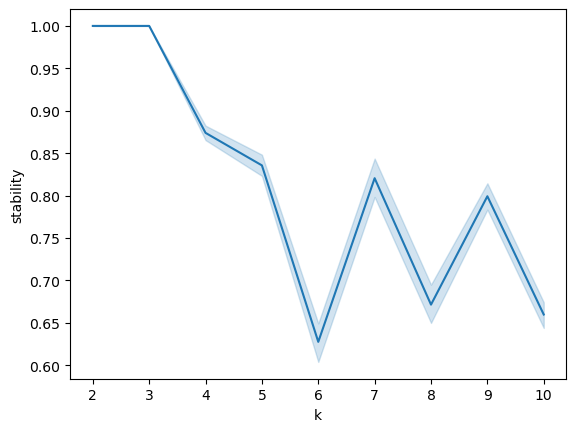

In [130]:
sns.lineplot(data=df_plot, x="k", y="stability")

In [131]:
perf_ari = {}
perf_nmi = {}
for k in KS:
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding"
            + " may not work as expected.",
            category=UserWarning,
        )
        model = cluster.SpectralClustering(n_clusters=k, affinity="nearest_neighbors")
        part = model.fit_predict(X)
    perf_ari[k] = ari(part, data_labels)
    perf_nmi[k] = nmi(part, data_labels)

In [132]:
_tmp = pd.DataFrame(
    {
        "ari": perf_ari,
        "nmi": perf_nmi,
    },
    index=KS,
)
display(_tmp)

ari       nmi
2   1.000000  1.000000
3   0.748884  0.800066
4   0.665925  0.716786
5   0.414779  0.608069
6   0.329465  0.558095
7   0.288693  0.528014
8   0.262905  0.506324
9   0.220301  0.480971
10  0.196244  0.463557

In [133]:
_tmp.corr()

ari       nmi
ari  1.000000  0.993966
nmi  0.993966  1.000000

_Answer_:
1. There seems to be stable clusters at $K$ equal to 2 and 3.
2. $K=2$, with perfect agreement with the true labels.
3. Yes, they coincide. However, the stability analysis is also high for other $K$ values.

#### Question 4

In [134]:
perf_s = {}
perf_c = {}
perf_d = {}
for k in KS:
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding"
            + " may not work as expected.",
            category=UserWarning,
        )
        model = cluster.SpectralClustering(n_clusters=k, affinity="nearest_neighbors")
        part = model.fit_predict(X)

    perf_s[k] = silhouette_score(X, part)
    perf_c[k] = calinski_harabasz_score(X, part)
    perf_d[k] = davies_bouldin_score(X, part)

In [135]:
_tmp = pd.DataFrame(
    {
        "Silhouette": perf_s,
        "CH": perf_c,
        "DB": perf_d,
    },
    index=KS,
)
display(_tmp)

Silhouette          CH          DB
2     0.109704    0.010231  147.481256
3     0.180595   59.245744    1.948126
4     0.224799   99.763376    1.238579
5     0.265185  105.096724    1.331782
6     0.255912  106.091070    1.240839
7     0.337345  146.094853    1.150909
8     0.393211  180.289172    0.927222
9     0.400142  197.634430    0.946012
10    0.378416  192.162670    0.819556

In [136]:
_tmp.corr()

Silhouette        CH        DB
Silhouette    1.000000  0.989455 -0.642314
CH            0.989455  1.000000 -0.694074
DB           -0.642314 -0.694074  1.000000

_Answer_:
1. No, internal metrics of clustering quality do not match solutions with the highest accuracy. The most accurate solutions ($K=2$ and $K=3$) tend to have the worst internal metric values. This is because these internal metrics have specific assumptions: Silhouette, for example, is a measure of cluster distance, but with concentric circles, this definition is blurry.
2. Yes, between Silhouette and CH, but not as much with DB.

#### Question 5

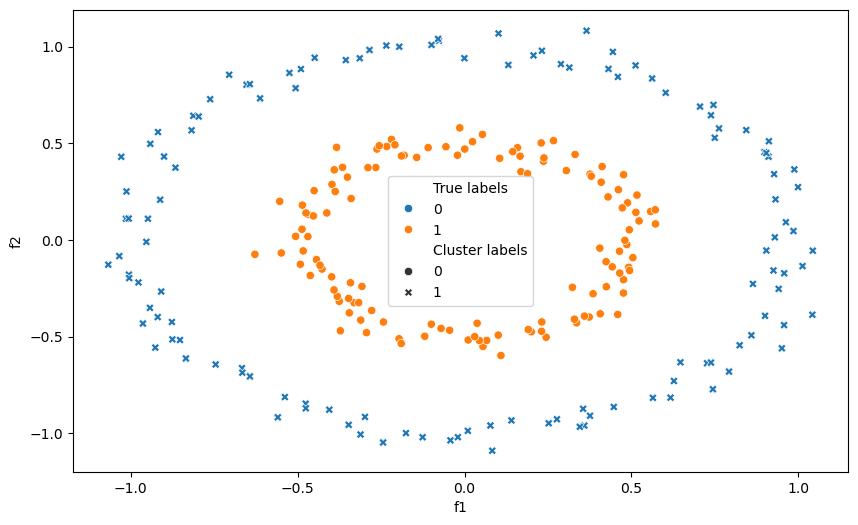

In [137]:
fig, ax = plt.subplots(figsize=(10, 6))

with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore",
        message="Graph is not fully connected, spectral embedding"
        + " may not work as expected.",
        category=UserWarning,
    )
    model = cluster.SpectralClustering(n_clusters=2, affinity="nearest_neighbors")
    part = model.fit_predict(X)

true_labels = pd.Series(data_labels).astype("category").rename("True labels")
cluster_labels = pd.Series(part).astype("category").rename("Cluster labels")

ax = sns.scatterplot(
    data,
    x="f1",
    y="f2",
    hue=true_labels,
    style=cluster_labels,
)

# ax.scatter(
#     model.cluster_centers_[:, 0],
#     model.cluster_centers_[:, 1],
#     marker="D",
#     color="red",
#     s=100,
# )

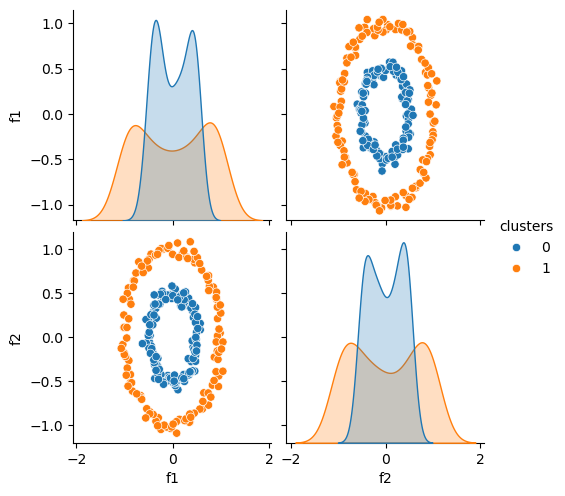

In [138]:
sns.pairplot(data.assign(clusters=cluster_labels), hue="clusters")

_Answer_: The two features are important.

### DBSCAN

#### Question 3

In [139]:
X = data.to_numpy()

np.random.seed(0)

KS = np.linspace(0.20, 0.50, 10)

perf_ari = {}
perf_nmi = {}
for k in KS:
    model = cluster.DBSCAN(eps=k)
    # model = cluster.OPTICS(max_eps=k)
    part = model.fit_predict(X).astype(float)
    assert (
        part[part < 0].shape[0] == 0
    ), "DBSCAN return noisy points; try other parameters"

    perf_ari[k] = ari(part, data_labels)
    perf_nmi[k] = nmi(part, data_labels)

In [140]:
_tmp = pd.DataFrame(
    {
        "ari": perf_ari,
        "nmi": perf_nmi,
    },
    index=KS,
)
display(_tmp.sort_values("ari"))

ari  nmi
0.433333  0.0  0.0
0.400000  0.0  0.0
0.366667  0.0  0.0
0.333333  0.0  0.0
0.500000  0.0  0.0
0.466667  0.0  0.0
0.300000  1.0  1.0
0.266667  1.0  1.0
0.200000  1.0  1.0
0.233333  1.0  1.0

In [141]:
_tmp.corr()

ari  nmi
ari  1.0  1.0
nmi  1.0  1.0

_Answer_:
1. NA (stability analysis here is not possible, at least in the same way we are doing it)
2. $eps=0.233$ and other similar values, with perfect agreement with the true labels.
3. NA.

#### Question 4

In [142]:
perf_s = {}
perf_c = {}
perf_d = {}
for k in KS:
    model = cluster.DBSCAN(eps=k)
    part = model.fit_predict(X)
    if len(np.unique(part)) > 1:
        perf_s[k] = silhouette_score(X, part)
        perf_c[k] = calinski_harabasz_score(X, part)
        perf_d[k] = davies_bouldin_score(X, part)

In [143]:
_tmp = pd.DataFrame(
    {
        "Silhouette": perf_s,
        "CH": perf_c,
        "DB": perf_d,
    },
    index=KS,
)
display(_tmp.sort_values("Silhouette"))

Silhouette        CH          DB
0.200000    0.109704  0.010231  147.481256
0.233333    0.109704  0.010231  147.481256
0.266667    0.109704  0.010231  147.481256
0.300000    0.109704  0.010231  147.481256
0.333333         NaN       NaN         NaN
0.366667         NaN       NaN         NaN
0.400000         NaN       NaN         NaN
0.433333         NaN       NaN         NaN
0.466667         NaN       NaN         NaN
0.500000         NaN       NaN         NaN

In [144]:
_tmp.dropna().corr()

Silhouette  CH  DB
Silhouette         NaN NaN NaN
CH                 NaN NaN NaN
DB                 NaN NaN NaN

_Answer_:
1. All values are very low.
2. NA (DBSCAN here always returns the same partition for different values of `eps`)

#### Question 5

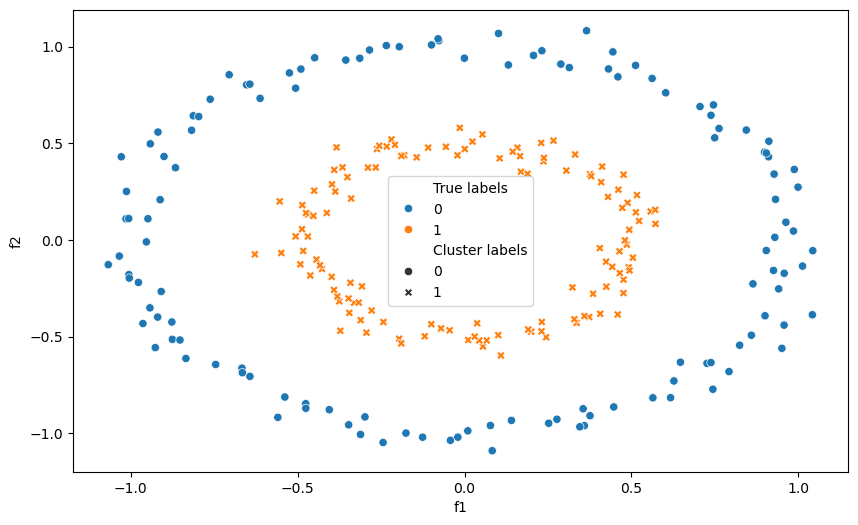

In [145]:
fig, ax = plt.subplots(figsize=(10, 6))

model = cluster.DBSCAN(eps=0.300000)
part = model.fit_predict(X)

true_labels = pd.Series(data_labels).astype("category").rename("True labels")
cluster_labels = pd.Series(part).astype("category").rename("Cluster labels")

ax = sns.scatterplot(
    data,
    x="f1",
    y="f2",
    hue=true_labels,
    style=cluster_labels,
)

# ax.scatter(
#     model.cluster_centers_[:, 0],
#     model.cluster_centers_[:, 1],
#     marker="D",
#     color="red",
#     s=100,
# )

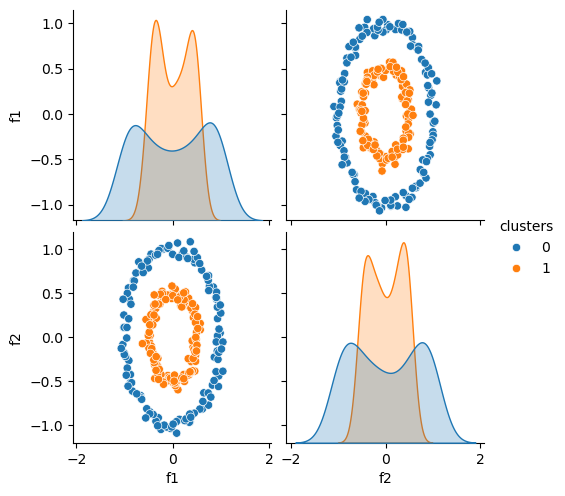

In [146]:
sns.pairplot(data.assign(clusters=cluster_labels), hue="clusters")

_Answer_: The two features are important.

### Hierarchical Clustering

#### Question 3

In [147]:
# 1. Are there stable clusters in the data?
X = data.to_numpy()

np.random.seed(0)

KS = range(2, 11)
N_REPS = 20

ks = []
stability_scores = []

for k in KS:
    labels = []

    for _ in range(N_REPS):
        with warnings.catch_warnings():
            model = cluster.AgglomerativeClustering(n_clusters=k, linkage="single")
            labels.append(model.fit_predict(X))

    # compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)

    ks.extend([k] * len(ari_distances))
    stability_scores.extend(ari_distances)

In [148]:
len(ks)

1710

In [149]:
len(stability_scores)

1710

In [150]:
df_plot = pd.DataFrame({
    "k": ks,
    "stability": stability_scores,
})

In [151]:
df_plot.shape

(1710, 2)

In [152]:
df_plot.head()

k  stability
0  2        1.0
1  2        1.0
2  2        1.0
3  2        1.0
4  2        1.0

In [153]:
df_plot["k"].value_counts()

k
2     190
3     190
4     190
5     190
6     190
7     190
8     190
9     190
10    190
Name: count, dtype: int64

<Axes: xlabel='k', ylabel='stability'>

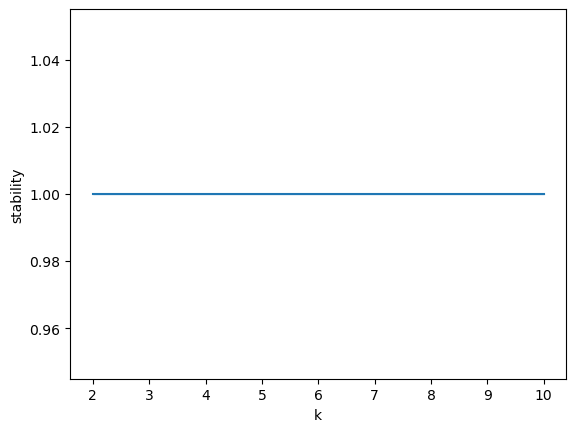

In [154]:
sns.lineplot(data=df_plot, x="k", y="stability")

**IMPORTANT**: Stability here does not make sense because the algorithm always returns the same partition given a $K$.

One heuristic to pick a $k$ for hierarchical clustering is to plot the [dendrogram](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html) and select the largest gap. In the example in the link, the largest gap is for $k=2$:

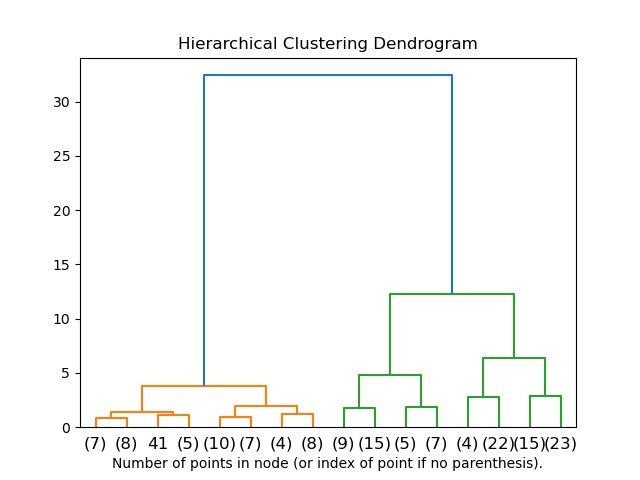

In [155]:
perf_ari = {}
perf_nmi = {}
for k in KS:
    model = cluster.AgglomerativeClustering(n_clusters=k, linkage="single")
    part = model.fit_predict(X)
    perf_ari[k] = ari(part, data_labels)
    perf_nmi[k] = nmi(part, data_labels)

In [156]:
_tmp = pd.DataFrame(
    {
        "ari": perf_ari,
        "nmi": perf_nmi,
    },
    index=KS,
)
display(_tmp)

ari       nmi
2   1.000000  1.000000
3   0.992032  0.983472
4   0.837707  0.838506
5   0.686025  0.722436
6   0.625713  0.664069
7   0.623458  0.658305
8   0.613596  0.637982
9   0.591936  0.609904
10  0.574915  0.587383

In [157]:
_tmp.corr()

ari       nmi
ari  1.000000  0.997494
nmi  0.997494  1.000000

_Answer_:
1. NA
2. $K=2$, with perfect agreement with the true labels. $K=3$ is also very close to perfect matching.
3. NA

#### Question 4

In [158]:
perf_s = {}
perf_c = {}
perf_d = {}
for k in KS:
    model = cluster.AgglomerativeClustering(n_clusters=k, linkage="single")
    part = model.fit_predict(X)
    perf_s[k] = silhouette_score(X, part)
    perf_c[k] = calinski_harabasz_score(X, part)
    perf_d[k] = davies_bouldin_score(X, part)

In [159]:
_tmp = pd.DataFrame(
    {
        "Silhouette": perf_s,
        "CH": perf_c,
        "DB": perf_d,
    },
    index=KS,
)
display(_tmp.sort_values("Silhouette"))

Silhouette         CH          DB
3    -0.009740   0.916303   69.035639
4    -0.000266  17.537930    3.936552
5     0.072355  56.168769    1.490905
9     0.086232  71.913916    0.772074
8     0.109008  66.821556    0.822472
10    0.109077  75.024372    0.742762
2     0.109704   0.010231  147.481256
7     0.120221  73.370451    0.872446
6     0.133684  87.140563    0.924786

In [160]:
_tmp.corr()

Silhouette        CH        DB
Silhouette    1.000000  0.687662 -0.106580
CH            0.687662  1.000000 -0.771076
DB           -0.106580 -0.771076  1.000000

_Answer_:
1. No, internal metrics of clustering quality do not match with solutions with the highest accuracy.
2. A little bit between Silhouette and CH, but not with DB.

#### Question 5

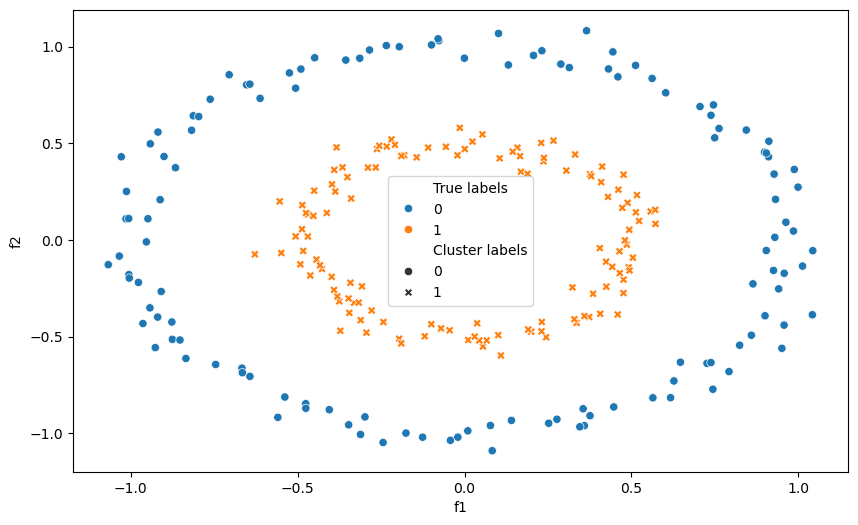

In [161]:
fig, ax = plt.subplots(figsize=(10, 6))

model = cluster.AgglomerativeClustering(n_clusters=2, linkage="single")
part = model.fit_predict(X)

true_labels = pd.Series(data_labels).astype("category").rename("True labels")
cluster_labels = pd.Series(part).astype("category").rename("Cluster labels")

ax = sns.scatterplot(
    data,
    x="f1",
    y="f2",
    hue=true_labels,
    style=cluster_labels,
)

# ax.scatter(
#     model.cluster_centers_[:, 0],
#     model.cluster_centers_[:, 1],
#     marker="D",
#     color="red",
#     s=100,
# )

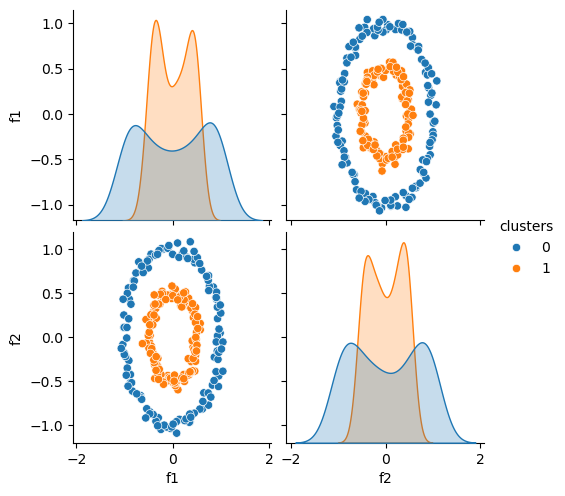

In [162]:
sns.pairplot(data.assign(clusters=cluster_labels), hue="clusters")

_Answer_: The two features are important.